#### The intention of this project is to attempt to predict if a movie is good or bad, simply from the text of it's reviews.

#### First, we need to obtain our training data from Imdb. We'll start by grabbing the top 100 all time movies from IMBD by using imdbpie.

In [1]:
from imdbpie import Imdb
imdb = Imdb(anonymize=True) # to proxy requests

In [2]:
# the imdbpie grabs the top 250, but we'll just use the top 100 of them
import pandas as pd
top = imdb.top_250()
df_top = pd.DataFrame(top)

In [4]:
# and using a modification of imdbpie's top_250 method, we'll grab the worse films
class Imdb_sup(Imdb):
    def bottom(self):
        url = self._build_url('/chart/bottom', {})
        response = self._get(url)
        return response['data']['list']['list']

In [5]:
imdb2 = Imdb_sup(anonymize=True)
bottom = imdb2.bottom()
df_bot = pd.DataFrame(bottom)

In [6]:
# drop the unnecessary columns
df_top.drop(df_top.columns[[0,1,2,6]], axis=1, inplace=True)
df_top.head()

,rating,tconst,title,year
0,9.3,tt0111161,The Shawshank Redemption,1994
1,9.2,tt0068646,The Godfather,1972
2,9.0,tt0071562,The Godfather: Part II,1974
3,9.0,tt0468569,The Dark Knight,2008
4,8.9,tt0050083,12 Angry Men,1957


In [8]:
# drop the unnecessary columns
df_bot.drop(df_bot.columns[[0,1,2,6]], axis=1, inplace=True)
df_bot.head()

,rating,tconst,title,year
0,1.7,tt4458206,Code Name: K.O.Z.,2015
1,1.5,tt4009460,Saving Christmas,2014
2,1.9,tt0270846,Superbabies: Baby Geniuses 2,2004
3,1.9,tt0421051,Daniel der Zauberer,2004
4,1.9,tt0060666,Manos: The Hands of Fate,1966


In [9]:
# reduce the top data set to just the top rated 100
df_t100 = df_top[:100].sort_values(['rating'])

In [10]:
# reduce the bottom data set to just the bottom 100
df_b100 = df_bot[:100].sort_values(['rating'], ascending=False)

In [14]:
df_all = pd.concat([df_t100, df_b100])

#### Now that we have our list of UUIDs for the movies we want to take reviews from, we have to obtain the actual reviews and the ratings associated with them.

In [45]:
rev_rate = []

for i in df_all['tconst']:
    data = imdb.get_title_reviews(i, max_results=1)
    rev_rate.append((data[0].text, data[0].rating))

In [65]:
# convert our list to a dataframe
df = pd.DataFrame(rev_rate, columns=['Review', 'Rating'])


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
Review    200 non-null object
Rating    163 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


In [67]:
df2 = df.dropna().copy()

In [88]:
# so now we have a dataframe that contains our reviews and our associated ratings
# time to review

In [85]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('white')
%matplotlib inline

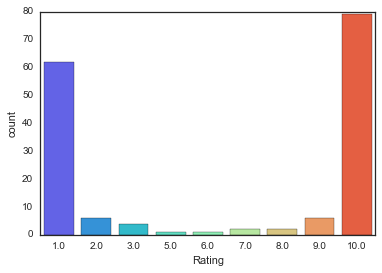

In [87]:
sb.countplot(x='Rating',data=df2,palette='rainbow')

In [93]:
df2['Rating'].value_counts()

10.0    79
1.0     62
9.0      6
2.0      6
3.0      4
8.0      2
7.0      2
6.0      1
5.0      1
Name: Rating, dtype: int64

#### Ok, so the data is already pretty bifurcated. Now to run some NLP madness on it.

In [111]:
# make our targets 1s and 0s

In [112]:
def rate(col):
    if col > 5.0:
        return 1
    else:
        return 0

In [118]:
df2['Qual'] = df2['Rating'].apply(rate)

/Users/deepstructure/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [119]:
df2.head()

,Review,Rating,Qual
0,"Ohhh - after my 4th or 5th viewing, I think th...",10.0,1
1,It's hard to judge a film such as this. Its co...,10.0,1
2,\nA towering classic of American cinematic pow...,10.0,1
3,\nTo Kill a Mockingbird is the movie based on ...,10.0,1
4,I attended a special screening for Toy Story 3...,10.0,1


In [120]:
# now we'll set our X and y values
X = df2['Review']
y = df2['Qual']

In [136]:
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

stop = STOPWORDS
porter = PorterStemmer()

def tokenizer_porter(text):
   return [porter.stem(word) for word in text.split()]


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [None, tokenizer_porter],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0]}]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])


gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=2,
                           verbose=1,
                           n_jobs=-1)

In [137]:
gs_lr_tfidf.fit(X,y)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   14.5s finished


GridSearchCV(cv=2, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tru...nalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'vect__ngram_range': [(1, 1)], 'vect__tokenizer': [None, <function tokenizer_porter at 0x11a9dede8>], 'clf__penalty': ['l1', 'l2'], 'clf__C': [1.0, 10.0], 'vect__stop_words': [set(['', 'all', "she'll", 'just', "don't", 'being', 'over', 'through', 'yourselves', 'its', 'before', "he's", "...i', "she'd", 'yours', "you'll", 'so', "we're", "she's", 'the', "that's", 'having', 'once']), None]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=1

#### Now we need to get our 2016 data to test against

In [142]:
import requests 
from scrapy.selector import Selector

HTML_top = requests.get('http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,desc').text
HTML_bot = requests.get('http://www.imdb.com/search/title?year=2016,2016&title_type=feature&sort=user_rating,asc').text

In [145]:
top_list = Selector(text=HTML_top).xpath('//*[@id="main"]/div/div/div/div/div/h3//a').extract()
bot_list = Selector(text=HTML_bot).xpath('//*[@id="main"]/div/div/div/div/div/h3//a').extract()

In [153]:
top_list[0]

u'<a href="/title/tt5825058/?ref_=adv_li_tt">The Randomer</a>'

In [184]:
# create a list of the ids

import re
list_tconst = []

for i in top_list:
    list_tconst.append(re.findall(r'tt\d+', i)[0])
    
for i in bot_list:
    list_tconst.append(re.findall(r'tt\d+', i)[0])

In [237]:
rev_rate2 = []

for i in list_tconst:
    data = imdb.get_title_reviews(i, max_results=1)
    if data is None:
        continue
    else:
        rev_rate2.append((data[0].text, data[0].rating))    

In [238]:
# convert our list to a dataframe
df_2016 = pd.DataFrame(rev_rate2, columns=['Review', 'Rating'])

In [241]:
df_2016.head()

,Review,Rating
0,"This is my first IMDb review, please excuse my...",10.0
1,Gurmeet ram raheem as a lionheart start the mo...,10.0
2,"I wasn't expecting a lot from this. No stars, ...",NaN
3,Dragonfly is the best indie movie I've seen in...,10.0
4,This film was so beautifully shot and full of ...,8.0


In [244]:
df_2016a = df_2016.dropna()

In [245]:
df_2016a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 0 to 37
Data columns (total 2 columns):
Review    33 non-null object
Rating    33 non-null float64
dtypes: float64(1), object(1)
memory usage: 792.0+ bytes


In [247]:
df_2016a['Qual'] = df_2016a['Rating'].apply(rate)

/Users/deepstructure/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [261]:
df_2016a.head()

,Review,Rating,Qual
0,"This is my first IMDb review, please excuse my...",10.0,1
1,Gurmeet ram raheem as a lionheart start the mo...,10.0,1
3,Dragonfly is the best indie movie I've seen in...,10.0,1
4,This film was so beautifully shot and full of ...,8.0,1
5,This movie is going to be a hit! The cast and ...,10.0,1


In [262]:
df_2016a['Qual'].value_counts()

0    19
1    14
Name: Qual, dtype: int64

In [252]:
X_test = df_2016a['Review']
y_test = df_2016a['Qual']

In [292]:
from sklearn.metrics import confusion_matrix,classification_report

In [293]:
predictions = gs_lr_tfidf.predict(X_test)

In [294]:
def print_cm_cr(y_test, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    print confusion
    print
    print classification_report(y_test, y_pred)
    
print_cm_cr(y_test, predictions)

Predicted   0   1  All
Actual                
0          14   5   19
1           3  11   14
All        17  16   33

             precision    recall  f1-score   support

          0       0.82      0.74      0.78        19
          1       0.69      0.79      0.73        14

avg / total       0.77      0.76      0.76        33



In [299]:
y_test_data = np.array(y_test)
pred_data = np.array(predictions)
combined = zip(y_test_data,pred_data)

In [309]:
compare = pd.DataFrame(combined, columns=['Actual', 'Predicted'])
compare

,Actual,Predicted
0,1,1
1,1,0
2,1,1
3,1,1
4,1,1
5,1,1
6,1,0
7,0,1
8,1,1
9,1,0


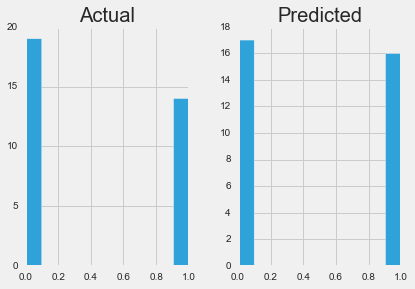

In [312]:
compare.hist()
plt.show()